In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/ import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch
import string

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=10,6
plt.rcParams['axes.grid']=True
plt.gray()

use_cuda = True
pd.set_option('display.max_columns', None)

<Figure size 720x432 with 0 Axes>

In [9]:
train = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv") 
test = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv") 
sample_submission = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/sample_submission.csv") 

In [10]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [11]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [12]:
test.shape

(3534, 3)

In [13]:
sample_submission.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


In [14]:
# Checking the shape of train and test data
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [15]:
# Checking Missing value in the training set
print(train.isnull().sum())
# Checking Missing Value in the testing set
print(test.isnull().sum())

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
textID       0
text         0
sentiment    0
dtype: int64


In [16]:
# Création d'une fonction permettant de calculer le total de valeurs manquantes, le pourcentage et le type de 
 ## chaque colonne 
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [17]:
missing_data(train)

,textID,text,selected_text,sentiment
Total,0,1,1,0
Percent,0,0.00363888,0.00363888,0
Types,object,object,object,object


In [18]:
missing_data(test)

,textID,text,sentiment
Total,0,0,0
Percent,0,0,0
Types,object,object,object


In [19]:
percent_sentiment = train.groupby('sentiment').count()
percent_sentiment['percent'] = 100*(percent_sentiment['text']/train['sentiment'].count())
percent_sentiment.reset_index(level=0, inplace=True)
percent_sentiment

,sentiment,textID,text,selected_text,percent
0,negative,7781,7781,7781,28.314108
1,neutral,11118,11117,11117,40.453404
2,positive,8582,8582,8582,31.228849


In [20]:
# Droping the row with missing values
train.dropna(axis = 0, how ='any',inplace=True)

In [21]:
# Positive tweet
print("Positive Tweet example :",train[train['sentiment']=='positive']['text'].values[0])
#negative_text
print("Negative Tweet example :",train[train['sentiment']=='negative']['text'].values[0])
#neutral_text
print("Neutral tweet example  :",train[train['sentiment']=='neutral']['text'].values[0])

Positive Tweet example : 2am feedings for the baby are fun when he is all smiles and coos
Negative Tweet example :  Sooo SAD I will miss you here in San Diego!!!
Neutral tweet example  :  I`d have responded, if I were going


In [22]:
# Distribution of the Sentiment Column
train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

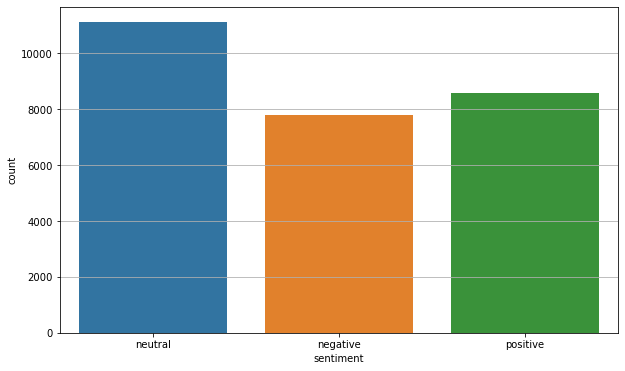

In [23]:
# Train data 
sns.countplot(x=train['sentiment'],data=train)
plt.show()

In [24]:
train['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

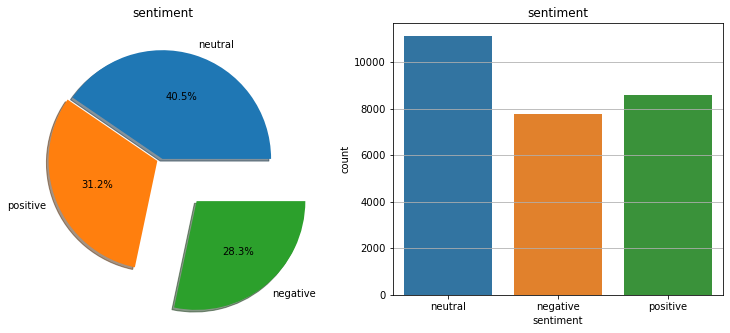

In [25]:
f,ax=plt.subplots(1,2,figsize=(13,5))
train['sentiment'].value_counts().plot.pie(explode=[0,0.05,0.5],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('sentiment')
ax[0].set_ylabel('')
sns.countplot('sentiment',data=train,ax=ax[1])
ax[1].set_title('sentiment')
plt.show()

In [26]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk import wordnet, pos_tag
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords, wordnet as wn
import re
import string

#Cleaning data

def clean_str(chaine):
    chaine = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", chaine)     
    chaine = re.sub(r"\'s", " \'s", chaine) 
    chaine = re.sub(r"\'ve", " \'ve", chaine) 
    chaine = re.sub(r"n\'t", " n\'t", chaine) 
    chaine = re.sub(r"\'re", " \'re", chaine) 
    chaine = re.sub(r"\'d", " \'d", chaine) 
    chaine = re.sub(r"\'ll", " \'ll", chaine) 
    chaine = re.sub(r",", " , ", chaine) 
    chaine = re.sub(r"!", " ! ", chaine) 
    chaine = re.sub(r"\(", " \( ", chaine) 
    chaine = re.sub(r"\)", " \) ", chaine) 
    chaine = re.sub(r"\?", " \? ", chaine) 
    chaine = re.sub(r"\s{2,}", " ", chaine)
    chaine = chaine.lower() #convert all text in lower case
    chaine = chaine.replace(' +', ' ') # Remove double space
    chaine = chaine.strip() # Remove trailing space at the beginning or end
    chaine = chaine.replace('[^a-zA-Z]', ' ' )# Everything not a alphabet character replaced with a space
    #words =  [word for word in chaine.split() if word not in [i for i in string.punctuation]] #Remove punctuations
    words =  [word for word in chaine.split() if word.isalpha()] #droping numbers and punctuations
    return ' '.join(words)

#Tokenization and punctuation removing and stopwords
def tokeniZ_stopWords(chaine):
    chaine = word_tokenize(chaine)
    list_stopWords = set(stopwords.words('english'))
    words = [word for word in chaine if word not in list_stopWords]
    return words

#Stemming 
ps = PorterStemmer()
sb = SnowballStemmer('english')

#Lemmatization
def lemat_words(tokens_list):
    from collections import defaultdict
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    lemma_function = WordNetLemmatizer()
    return [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens_list)]
    #for token, tag in pos_tag(tokens_list):
     #   lemma = lemma_function.lemmatize(token, tag_map[tag[0]])

# Define Ngrams function
def get_ngrams(text, n ):
    n_grams = ngrams(word_tokenize(text), n)
    return [ ' '.join(grams) for grams in n_grams]

## text

In [27]:
#Cleaning the train data 
train['text_clean'] = train['text'].apply(clean_str)

#Tokenizing and stopwords removing
train['tokeniZ_stopWords_text'] = train['text_clean'].apply(tokeniZ_stopWords)
#Words Stemming
train['stemming_text'] = [[ps.stem(word) for word in words] for words in train['tokeniZ_stopWords_text'] ]
train['stemming_text_for_tfidf'] = [' '.join(words) for words in train['stemming_text']] 

#Words lemmatization
train['lemmatize_text'] = train['tokeniZ_stopWords_text'].apply(lemat_words)
train['lemmatize_text_for_tfidf'] = [' '.join(x) for x in train['lemmatize_text'] ]

#Calcul longueur des commentaires
train['text_lenght'] = train['text'].apply(len)

#Calcul du nombre de ponctuation par question
from string import punctuation
train['number_punctuation_text'] = train['text'].apply(
    lambda doc: len([word for word in str(doc) if word in punctuation])) 

#Number of unique words in the text
train['number_of_Unique_words_text'] = train['text_clean'].apply([lambda x : len(set(str(x).split()))])

#Number of stopwords in the text
list_stopWords = set(stopwords.words('english'))
train['number_of_StopWords_text'] = train['text_clean'].apply(
    lambda x : len([w for w in x.lower().split() if w in list_stopWords ]))


#Number of upper case words
train['number_of_uppercase_text'] = train['text'].apply(
    lambda x : len([w for w in x.split() if w.isupper()]))


#Average length of words in the text (whithout stop words)
train['average_of_wordsLength_text'] = train['text_clean'].apply(
    lambda x : np.mean([len(w) for w in x.split()]))

#Number of words in the text
train['number_of_words_text'] = train['text_clean'].apply([lambda x : len(str(x).split())])

## selected_text

In [28]:

#Cleaning the train data 
train['selected_text_clean'] = train['selected_text'].apply(clean_str)

#Tokenizing and stopwords removing
train['tokeniZ_stopWords_text'] = train['selected_text_clean'].apply(tokeniZ_stopWords)

#Words Stemming
train['stemming_selected_text'] = [[ps.stem(word) for word in words] for words in train['tokeniZ_stopWords_text'] ]
train['stemming_selected_text_for_tfidf'] = [' '.join(words) for words in train['stemming_selected_text']] 

#Words lemmatization
train['lemmatize_selected_text'] = train['tokeniZ_stopWords_text'].apply(lemat_words)
train['lemmatize_selected_text_for_tfidf'] = [' '.join(x) for x in train['lemmatize_selected_text'] ]


#Calcul longueur des commentaires
train['selected_text_lenght'] = train['selected_text'].apply(len)

#Calcul du nombre de ponctuation par question
from string import punctuation
train['number_punctuation_selected_text'] = train['selected_text'].apply(
    lambda doc: len([word for word in str(doc) if word in punctuation])) 

#Number of unique words in the text
train['number_of_Unique_words_selected_text'] = train['selected_text_clean'].apply([lambda x : len(set(str(x).split()))])

#Number of stopwords in the text
list_stopWords = set(stopwords.words('english'))
train['number_of_StopWords_selected_text'] = train['selected_text_clean'].apply(
    lambda x : len([w for w in x.lower().split() if w in list_stopWords ]))


#Number of upper case words
train['number_of_uppercase_selected_text'] = train['selected_text'].apply(
    lambda x : len([w for w in x.split() if w.isupper()]))


#Average length of words in the text (whithout stop words)
train['average_of_wordsLength_selected_text'] = train['selected_text_clean'].apply(
    lambda x : np.mean([len(w) for w in x.split()]))

#Number of words in the text
train['number_of_words_selected_text'] = train['selected_text_clean'].apply([lambda x : len(str(x).split())])



In [29]:
# Let's create three separate dataframes for positive, neutral and negative sentiments. 
#This will help in analyzing the text statistics separately for separate polarities.

positive = train[train['sentiment']=='positive']
negative = train[train['sentiment']=='negative']
neutral = train[train['sentiment']=='neutral']

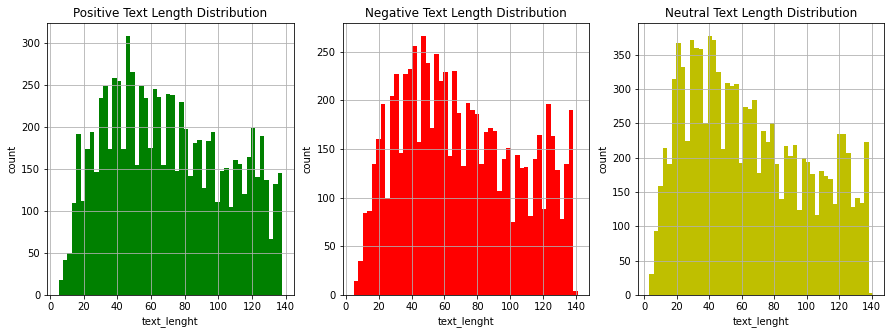

In [30]:
# Sentence length analysis

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(positive['text_lenght'],bins=50,color='g')
plt.title('Positive Text Length Distribution')
plt.xlabel('text_lenght')
plt.ylabel('count')


plt.subplot(1, 3, 2)
plt.hist(negative['text_lenght'],bins=50,color='r')
plt.title('Negative Text Length Distribution')
plt.xlabel('text_lenght')
plt.ylabel('count')


plt.subplot(1, 3, 3)
plt.hist(neutral['text_lenght'],bins=50,color='y')
plt.title('Neutral Text Length Distribution')
plt.xlabel('text_lenght')
plt.ylabel('count')
plt.show()

In [31]:
#source of code : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

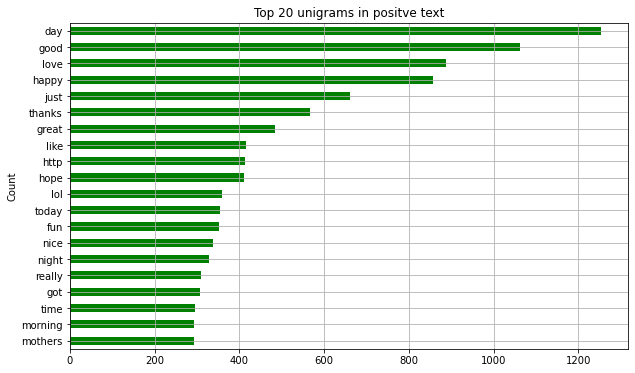

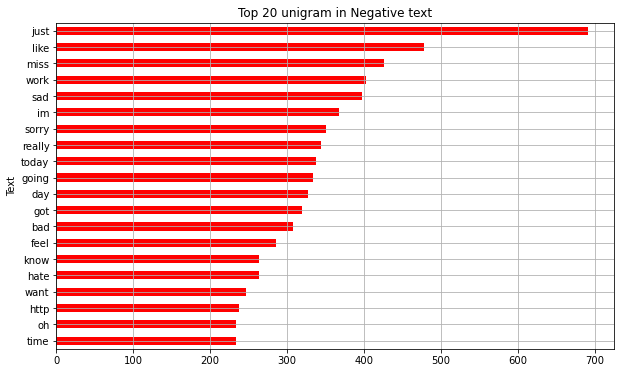

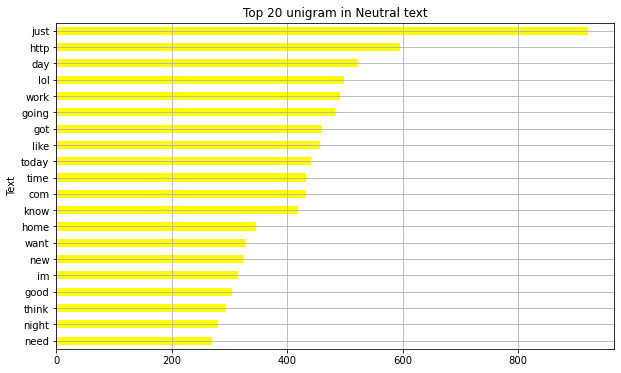

In [32]:
#Distribution of top unigrams
positive_unigrams = get_top_n_words(positive['text_clean'],20)
negative_unigrams = get_top_n_words(negative['text_clean'],20)
neutral_unigrams = get_top_n_words(neutral['text_clean'],20)

df1 = pd.DataFrame(positive_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='g')
plt.ylabel('Count')
plt.title('Top 20 unigrams in positve text')
plt.show()

df2 = pd.DataFrame(negative_unigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='red')
plt.title('Top 20 unigram in Negative text')
plt.show()

df3 = pd.DataFrame(neutral_unigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='yellow')
plt.title('Top 20 unigram in Neutral text')
plt.show()

In [33]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

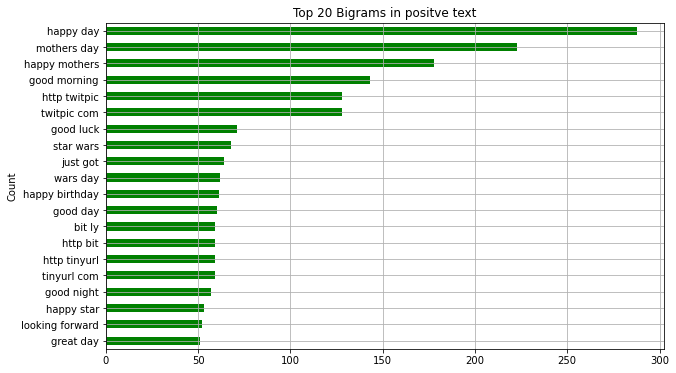

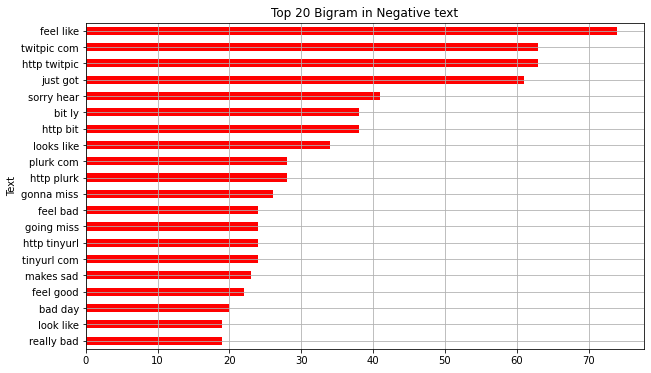

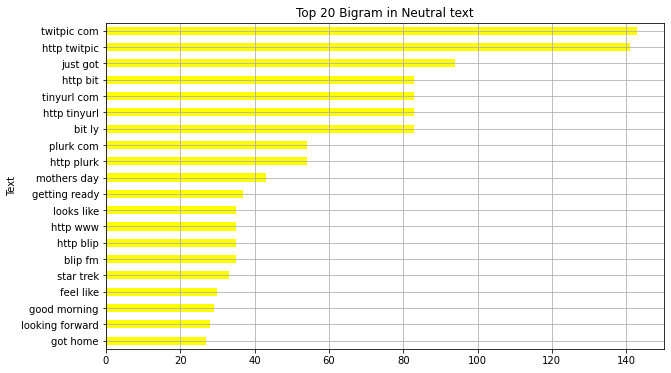

In [34]:
#Distribution of top Bigrams
positive_bigrams = get_top_n_gram(positive['text_clean'],(2,2),20)
negative_bigrams = get_top_n_gram(negative['text_clean'],(2,2),20)
neutral_bigrams = get_top_n_gram(neutral['text_clean'],(2,2),20)

df1 = pd.DataFrame(positive_bigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='g')
plt.ylabel('Count')
plt.title('Top 20 Bigrams in positve text')
plt.show()

df2 = pd.DataFrame(negative_bigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='red')
plt.title('Top 20 Bigram in Negative text')
plt.show()

df3 = pd.DataFrame(neutral_bigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='yellow')
plt.title('Top 20 Bigram in Neutral text')
plt.show()

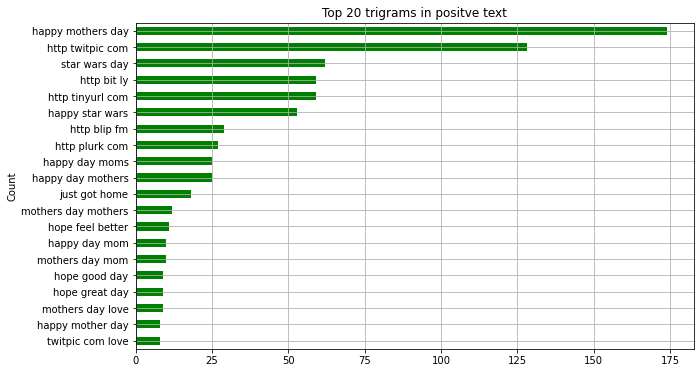

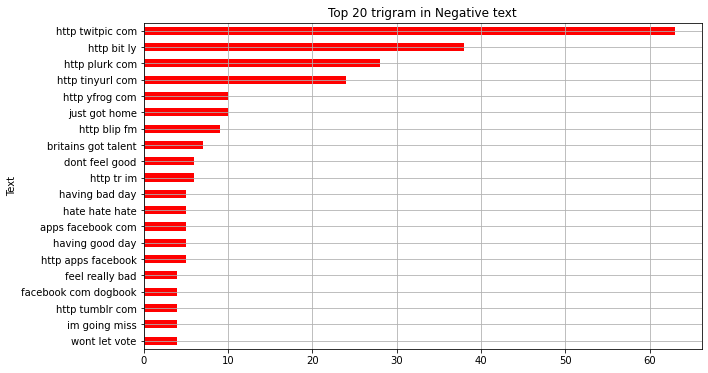

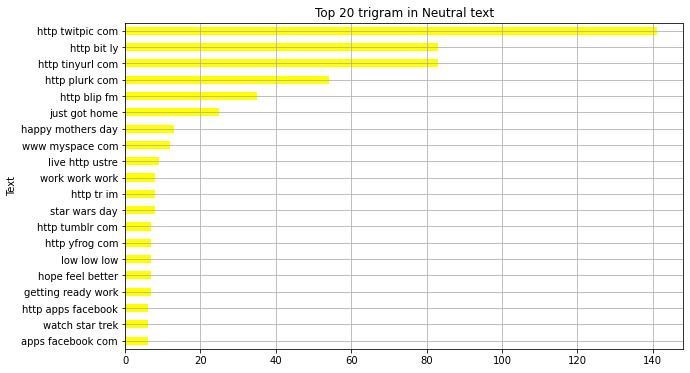

In [35]:
# Finding top trigram
positive_trigrams = get_top_n_gram(positive['text_clean'],(3,3),20)
negative_trigrams = get_top_n_gram(negative['text_clean'],(3,3),20)
neutral_trigrams = get_top_n_gram(neutral['text_clean'],(3,3),20)

df1 = pd.DataFrame(positive_trigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='g')
plt.ylabel('Count')
plt.title('Top 20 trigrams in positve text')
plt.show()

df2 = pd.DataFrame(negative_trigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='red')
plt.title('Top 20 trigram in Negative text')
plt.show()

df3 = pd.DataFrame(neutral_trigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='yellow')
plt.title('Top 20 trigram in Neutral text')
plt.show()



In [36]:
#  Exploring the selected_text column

positive_text = train[train['sentiment'] == 'positive']['selected_text']
negative_text = train[train['sentiment'] == 'negative']['selected_text']
neutral_text = train[train['sentiment'] == 'neutral']['selected_text']

In [37]:
# Positive text
print("Positive Text example :",positive_text.values[0])
#negative_text
print("Negative Tweet example :",negative_text.values[0])
#neutral_text
print("Neutral tweet example  :",neutral_text.values[0])

Positive Text example : fun
Negative Tweet example : Sooo SAD
Neutral tweet example  : I`d have responded, if I were going


In [38]:
# Preprocess Selected_text

positive_text_clean = positive_text.apply(clean_str)
negative_text_clean = negative_text.apply(clean_str)
neutral_text_clean = neutral_text.apply(clean_str)

In [39]:
#source of code : https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [40]:
top_words_in_positive_text = get_top_n_words(positive_text_clean)
top_words_in_negative_text = get_top_n_words(negative_text_clean)
top_words_in_neutral_text = get_top_n_words(neutral_text_clean)

p1 = [x[0] for x in top_words_in_positive_text[:20]]
p2 = [x[1] for x in top_words_in_positive_text[:20]]


n1 = [x[0] for x in top_words_in_negative_text[:20]]
n2 = [x[1] for x in top_words_in_negative_text[:20]]


nu1 = [x[0] for x in top_words_in_neutral_text[:20]]
nu2 = [x[1] for x in top_words_in_neutral_text[:20]]

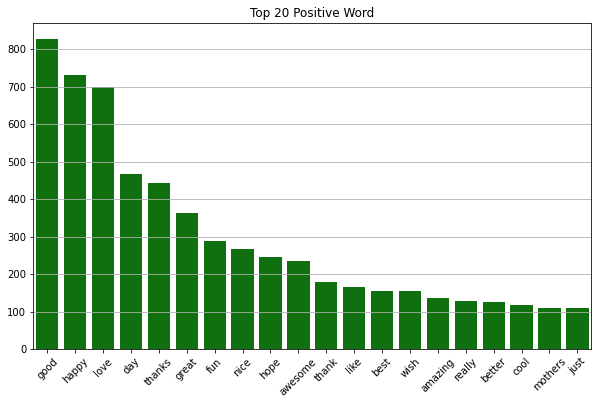

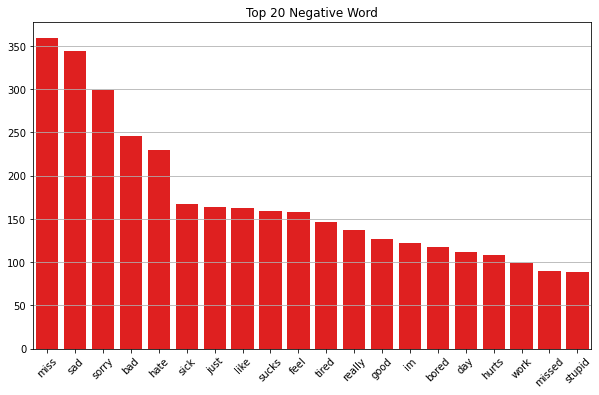

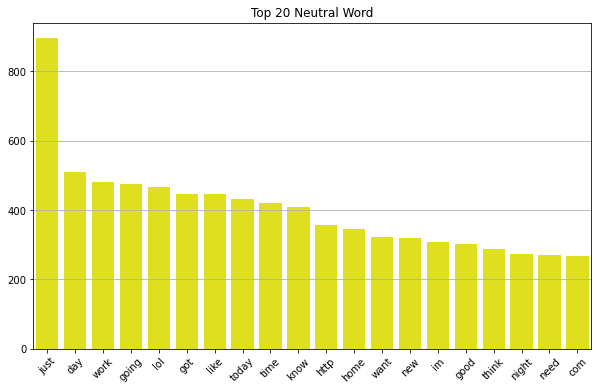

In [41]:
# Top positive word
sns.barplot(x=p1,y=p2,color = 'green')
plt.xticks(rotation=45)
plt.title('Top 20 Positive Word')
plt.show()

sns.barplot(x=n1,y=n2,color='red')
plt.xticks(rotation=45)
plt.title('Top 20 Negative Word')
plt.show()

sns.barplot(x=nu1,y=nu2,color='yellow')
plt.xticks(rotation=45)
plt.title('Top 20 Neutral Word')
plt.show()

Text(0.5, 1.0, 'Neutral text')

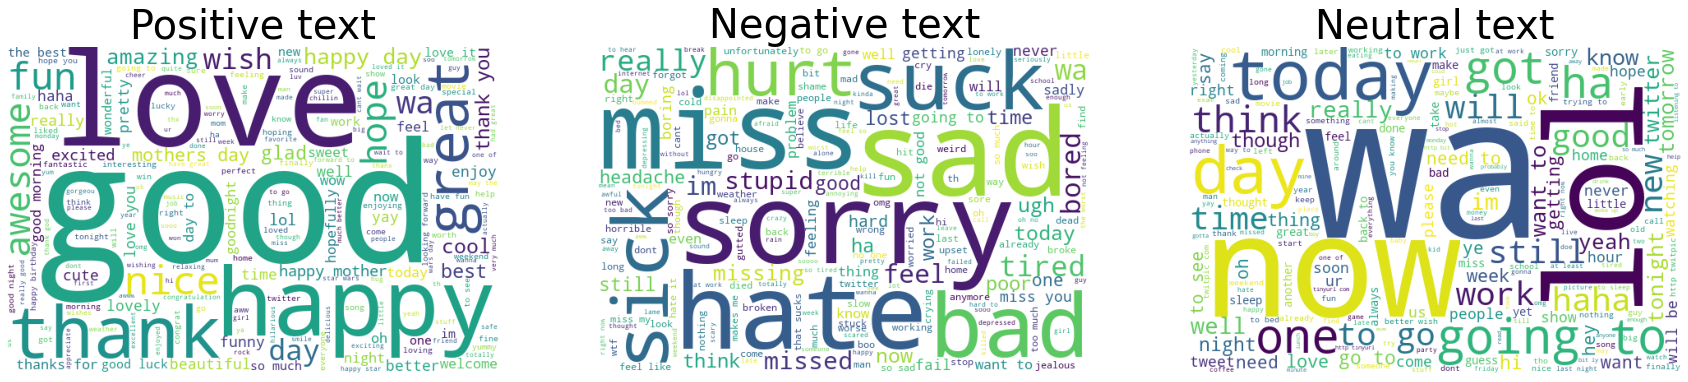

In [42]:
#Wordclouds
# Wordclouds to see which words contribute to which type of polarity.

from wordcloud import WordCloud
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=40)

In [43]:
# https://www.kaggle.com/ekhtiar/unintended-eda-with-tutorial-notes
def generate_word_cloud(df_data, text_col):
    # convert stop words to sets as required by the wordcloud library
    stop_words = set(stopwords.words("english"))
    
    data_neutral = " ".join(df_data.loc[df_data["sentiment"]=="neutral", text_col].map(lambda x: str(x).lower()))
    data_positive = " ".join(df_data.loc[df_data["sentiment"]=="positive", text_col].map(lambda x: str(x).lower()))
    data_negative = " ".join(df_data.loc[df_data["sentiment"]=="negative", text_col].map(lambda x: str(x).lower()))

    wc_neutral = WordCloud(max_font_size=100, max_words=100, background_color="white", stopwords=stop_words).generate(data_neutral)
    wc_positive = WordCloud(max_font_size=100, max_words=100, background_color="white", stopwords=stop_words).generate(data_positive)
    wc_negative = WordCloud(max_font_size=100, max_words=100, background_color="white", stopwords=stop_words).generate(data_negative)

    # draw the two wordclouds side by side using subplot
    fig, ax = plt.subplots(1, 3, figsize=(20, 20))
    ax[0].set_title("Neutral Wordcloud" , fontsize=10)
    ax[0].imshow(wc_neutral, interpolation="bilinear")
    ax[0].axis("off")
    
    ax[1].set_title("Positive Wordcloud", fontsize=10)
    ax[1].imshow(wc_positive, interpolation="bilinear")
    ax[1].axis("off")
    
    ax[2].set_title("Negative Wordcloud", fontsize=10)
    ax[2].imshow(wc_negative, interpolation="bilinear")
    ax[2].axis("off")
    plt.show()
    
    return [wc_neutral, wc_positive, wc_negative]

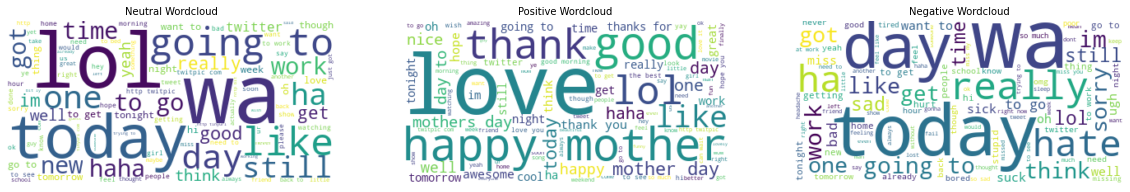

In [44]:
train_text_wc = generate_word_cloud(train, "text")


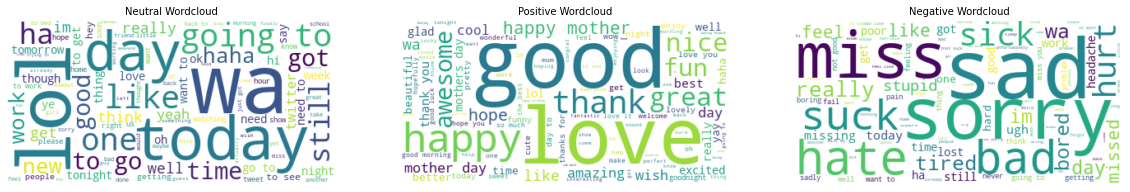

In [45]:
train_sel_text_wc = generate_word_cloud(train, "selected_text")

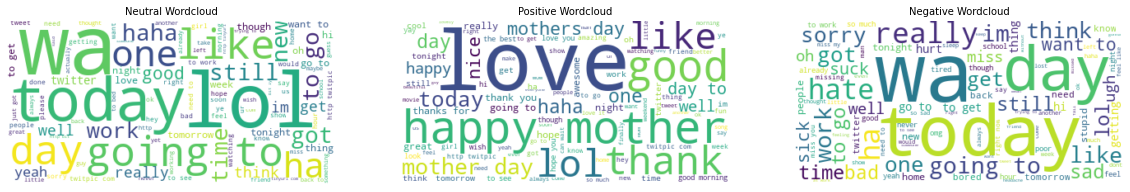

In [46]:
train_text_wc = generate_word_cloud(train, "text")

In [47]:
missing_data(train)

,textID,text,selected_text,sentiment,text_clean,tokeniZ_stopWords_text,stemming_text,stemming_text_for_tfidf,lemmatize_text,lemmatize_text_for_tfidf,text_lenght,number_punctuation_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text,number_of_words_text,selected_text_clean,stemming_selected_text,stemming_selected_text_for_tfidf,lemmatize_selected_text,lemmatize_selected_text_for_tfidf,selected_text_lenght,number_punctuation_selected_text,number_of_Unique_words_selected_text,number_of_StopWords_selected_text,number_of_uppercase_selected_text,average_of_wordsLength_selected_text,number_of_words_selected_text
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,132,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0218341,0,0,0,0,0,0,0,0,0,0,0,0.480349,0
Types,object,object,object,object,object,object,object,object,object,object,int64,int64,int64,int64,int64,float64,int64,object,object,object,object,object,int64,int64,int64,int64,int64,float64,int64


## Target variable creating 

In [48]:
train['Target'] = train['sentiment'].apply(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)
train.head()

,textID,text,selected_text,sentiment,text_clean,tokeniZ_stopWords_text,stemming_text,stemming_text_for_tfidf,lemmatize_text,lemmatize_text_for_tfidf,text_lenght,number_punctuation_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text,number_of_words_text,selected_text_clean,stemming_selected_text,stemming_selected_text_for_tfidf,lemmatize_selected_text,lemmatize_selected_text_for_tfidf,selected_text_lenght,number_punctuation_selected_text,number_of_Unique_words_selected_text,number_of_StopWords_selected_text,number_of_uppercase_selected_text,average_of_wordsLength_selected_text,number_of_words_selected_text,Target
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,have responded if i were going,"[responded, going]","[respond, go]",respond go,"[respond, go]",respond go,36,2,6,4,1,4.166667,6,have responded if i were going,"[respond, go]",respond go,"[respond, go]",respond go,35,2,6,4,1,4.166667,6,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,"[sooo, sad]","[sooo, sad, miss, san, diego]",sooo sad miss san diego,"[sooo, sad, miss, san, diego]",sooo sad miss san diego,46,3,10,5,2,3.300000,10,sooo sad,"[sooo, sad]",sooo sad,"[sooo, sad]",sooo sad,8,0,2,0,1,3.500000,2,0
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,[bullying],"[boss, bulli]",boss bulli,"[bos, bully]",bos bully,25,3,5,3,0,3.600000,5,bullying me,[bulli],bulli,[bullying],bullying,11,0,2,1,0,5.000000,2,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,"[leave, alone]","[interview, leav, alon]",interview leav alon,"[interview, leave, alone]",interview leave alone,31,1,5,2,0,5.000000,5,leave me alone,"[leav, alon]",leav alon,"[leave, alone]",leave alone,14,0,3,1,0,4.000000,3,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why they put them on the releases we a...,[sons],"[son, put, releas, alreadi, bought]",son put releas alreadi bought,"[son, put, release, already, buy]",son put release already buy,75,6,12,7,0,4.000000,12,sons of,[son],son,[son],son,13,5,2,1,0,3.000000,2,0


In [49]:
percent_target = train.groupby('Target').count()
percent_target['percent'] = 100*(percent_target['text']/train['Target'].count())
percent_target.reset_index(level=0, inplace=True)
percent_target

,Target,textID,text,selected_text,sentiment,text_clean,tokeniZ_stopWords_text,stemming_text,stemming_text_for_tfidf,lemmatize_text,lemmatize_text_for_tfidf,text_lenght,number_punctuation_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text,number_of_words_text,selected_text_clean,stemming_selected_text,stemming_selected_text_for_tfidf,lemmatize_selected_text,lemmatize_selected_text_for_tfidf,selected_text_lenght,number_punctuation_selected_text,number_of_Unique_words_selected_text,number_of_StopWords_selected_text,number_of_uppercase_selected_text,average_of_wordsLength_selected_text,number_of_words_selected_text,percent
0,0,7781,7781,7781,7781,7781,7781,7781,7781,7781,7781,7781,7781,7781,7781,7781,7780,7781,7781,7781,7781,7781,7781,7781,7781,7781,7781,7781,7673,7781,28.315138
1,1,11117,11117,11117,11117,11117,11117,11117,11117,11117,11117,11117,11117,11117,11117,11117,11113,11117,11117,11117,11117,11117,11117,11117,11117,11117,11117,11117,11113,11117,40.454876
2,2,8582,8582,8582,8582,8582,8582,8582,8582,8582,8582,8582,8582,8582,8582,8582,8581,8582,8582,8582,8582,8582,8582,8582,8582,8582,8582,8582,8562,8582,31.229985


## Features engineering for training data 

In [50]:
train.head(2)

,textID,text,selected_text,sentiment,text_clean,tokeniZ_stopWords_text,stemming_text,stemming_text_for_tfidf,lemmatize_text,lemmatize_text_for_tfidf,text_lenght,number_punctuation_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text,number_of_words_text,selected_text_clean,stemming_selected_text,stemming_selected_text_for_tfidf,lemmatize_selected_text,lemmatize_selected_text_for_tfidf,selected_text_lenght,number_punctuation_selected_text,number_of_Unique_words_selected_text,number_of_StopWords_selected_text,number_of_uppercase_selected_text,average_of_wordsLength_selected_text,number_of_words_selected_text,Target
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,have responded if i were going,"[responded, going]","[respond, go]",respond go,"[respond, go]",respond go,36,2,6,4,1,4.166667,6,have responded if i were going,"[respond, go]",respond go,"[respond, go]",respond go,35,2,6,4,1,4.166667,6,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,"[sooo, sad]","[sooo, sad, miss, san, diego]",sooo sad miss san diego,"[sooo, sad, miss, san, diego]",sooo sad miss san diego,46,3,10,5,2,3.300000,10,sooo sad,"[sooo, sad]",sooo sad,"[sooo, sad]",sooo sad,8,0,2,0,1,3.500000,2,0


In [51]:
train.tail()

,textID,text,selected_text,sentiment,text_clean,tokeniZ_stopWords_text,stemming_text,stemming_text_for_tfidf,lemmatize_text,lemmatize_text_for_tfidf,text_lenght,number_punctuation_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text,number_of_words_text,selected_text_clean,stemming_selected_text,stemming_selected_text_for_tfidf,lemmatize_selected_text,lemmatize_selected_text_for_tfidf,selected_text_lenght,number_punctuation_selected_text,number_of_Unique_words_selected_text,number_of_StopWords_selected_text,number_of_uppercase_selected_text,average_of_wordsLength_selected_text,number_of_words_selected_text,Target
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see u on denver husband los...,[lost],"[wish, could, come, see, u, denver, husband, l...",wish could come see u denver husband lost job ...,"[wish, could, come, see, u, denver, husband, l...",wish could come see u denver husband lose job ...,77,1,15,5,0,3.666667,15,d lost,[lost],lost,[lose],lose,6,0,2,1,0,2.500000,2,0
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,wondered about rake to the client has made it ...,[force],"[wonder, rake, client, made, clear, net, forc,...",wonder rake client made clear net forc dev lea...,"[wonder, rake, client, make, clear, net, force...",wonder rake client make clear net force devs l...,122,7,20,8,1,3.952381,21,force,[forc],forc,[force],force,13,2,1,0,0,5.000000,1,0
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you p...,"[yay, good]","[yay, good, enjoy, break, probabl, need, hecti...",yay good enjoy break probabl need hectic weeke...,"[yay, good, enjoy, break, probably, need, hect...",yay good enjoy break probably need hectic week...,111,2,20,9,0,4.095238,21,yay good for both of you,"[yay, good]",yay good,"[yay, good]",yay good,25,1,6,4,0,3.166667,6,2
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,but it was worth it,[worth],[worth],worth,[worth],worth,27,5,4,4,0,3.000000,5,but it was worth it,[worth],worth,[worth],worth,26,5,4,4,0,3.000000,5,2
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral,all this flirting going on the atg smiles yay ...,"[flirting, going, atg, smiles, yay, hugs]","[flirt, go, atg, smile, yay, hug]",flirt go atg smile yay hug,"[flirt, go, atg, smile, yay, hug]",flirt go atg smile yay hug,62,7,10,4,1,4.100000,10,all this flirting going on the atg smiles yay ...,"[flirt, go, atg, smile, yay, hug]",flirt go atg smile yay hug,"[flirt, go, atg, smile, yay, hug]",flirt go atg smile yay hug,58,6,10,4,1,4.100000,10,1


In [52]:
train[['text_lenght', 'number_punctuation_text', 'number_of_words_text',
       'number_of_Unique_words_text', 'number_of_StopWords_text', 'number_of_uppercase_text',
       'average_of_wordsLength_text']].sample(5)

,text_lenght,number_punctuation_text,number_of_words_text,number_of_Unique_words_text,number_of_StopWords_text,number_of_uppercase_text,average_of_wordsLength_text
7159,38,3,8,8,1,1,3.625000
20074,23,1,3,3,1,0,4.333333
3385,46,0,9,9,4,0,4.222222
24781,71,9,11,11,5,1,4.181818
18361,80,4,18,17,8,1,3.222222


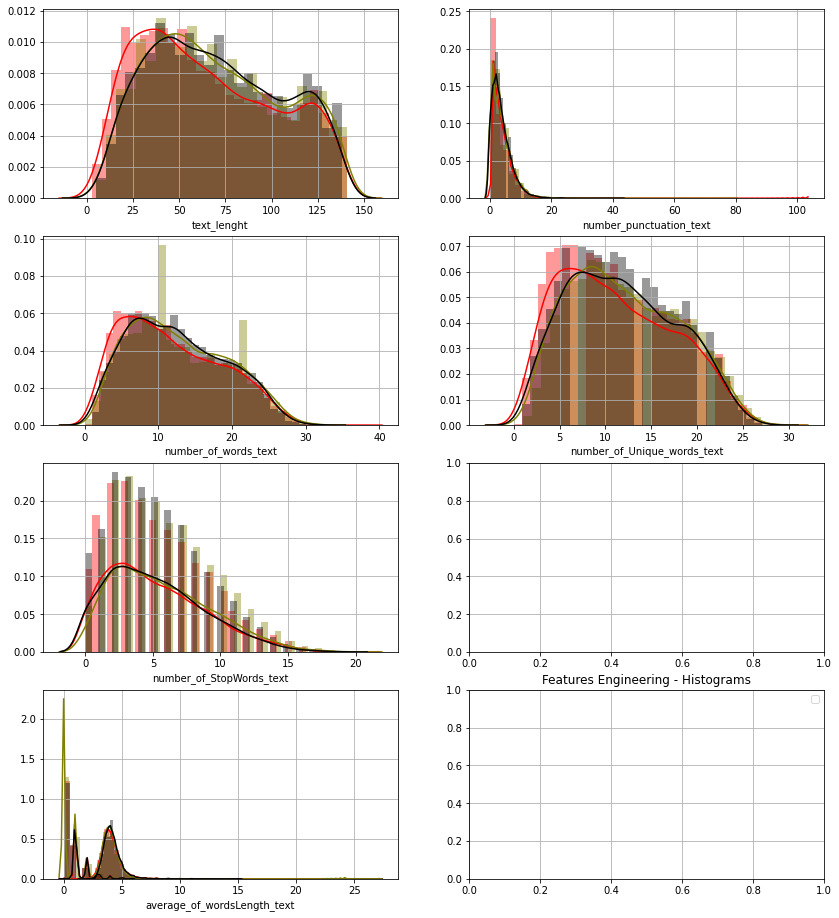

In [53]:
list_var=['text_lenght', 'number_punctuation_text', 'number_of_words_text',
       'number_of_Unique_words_text', 'number_of_StopWords_text', 'number_of_uppercase_text','average_of_wordsLength_text']
def var_hist_global(df,X='Target',Y=list_var, Title='Features Engineering - Histograms', KDE=False):
    fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6),(ax6,ax7)) = plt.subplots(4, 2 ,figsize=(14,16))#, sharey=True )
    aX = [ax1, ax2,ax3,ax4,ax5,ax6,ax6,ax7]
    for i in range(len(list_var)):   
        sns.distplot( df[list_var[i]][df[X]== 1 ].dropna(), label="Neutral" , ax= aX[i], kde= KDE , color = 'red')           
        sns.distplot( df[list_var[i]][df[X]== 0 ].dropna(), label="Negative", ax= aX[i], kde= KDE , color = "olive")
        sns.distplot( df[list_var[i]][df[X]== 2 ].dropna(), label="Positive", ax= aX[i], kde= KDE , color = "black")
    plt.legend()
    plt.title(Title)
    #plt.show()
    plt.savefig("Features_Engineering_Histograms")
    
var_hist_global(df=train,X='Target',Y=list_var, KDE=True)

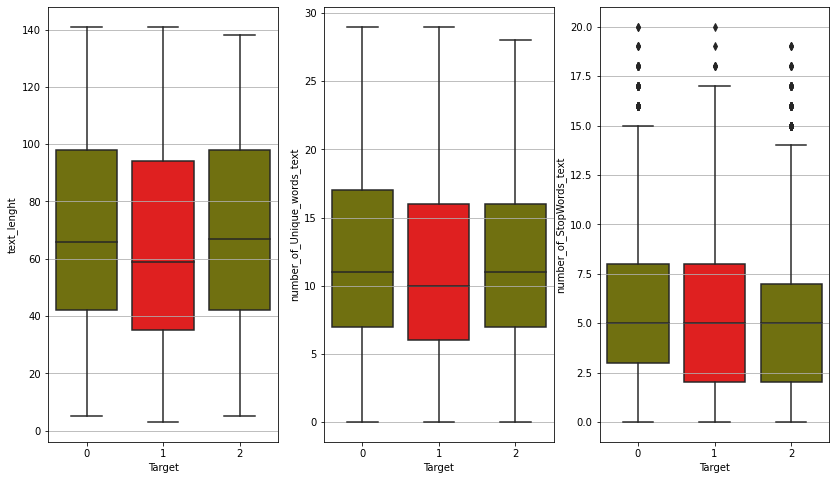

In [54]:
# Calculate number of obs per group & median to position labels
list_var = ['text_lenght', 'number_of_Unique_words_text', 'number_of_StopWords_text']
def violin_boxplott(df,X='Target',Y=list_var, Title='Features Engineering - Box plot'): 
    fig, (ax1, ax2 ,ax3) = plt.subplots(1,3 ,figsize=(14,8))#, sharey=True )
    medians = train.groupby(['Target'])['text_lenght', 'number_of_Unique_words_text', 'number_of_StopWords_text'].median().values
 
    sns.boxplot( y=list_var[0],  x=X , data = df, ax= ax1 , palette=['olive','red'])
    sns.boxplot( y=list_var[1],  x=X , data = df, ax= ax2 , palette=['olive','red'])
    sns.boxplot( y=list_var[2],  x=X , data = df, ax= ax3 , palette=['olive','red'])
    #plt.title(Title)
    plt.savefig("Features_Engineering_Boxplot")
violin_boxplott(df=train)

In [55]:
#Word2Vec with preprocessiong questions (without stopwords) 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

d2v_training_data = []
for i, doc in enumerate(train['stemming_selected_text']):
    d2v_training_data.append(TaggedDocument(words=doc,tags=[i]))

# ========== learning doc embeddings with doc2vec ==========

# PV stands for 'Paragraph Vector'
# PV-DBOW (distributed bag-of-words) dm=0

d2v = Doc2Vec(d2v_training_data, vector_size=300, window=10, alpha=0.1, min_alpha=1e-4, dm=0, negative=1, epochs=10, min_count=2, workers=4)
d2v_vecs = np.zeros((len(train['stemming_selected_text']), 300))
for i in range(len(train['stemming_selected_text'])):
    d2v_vecs[i,:] = d2v.docvecs[i]

In [56]:
#Word2Vec with lemmatize words
d2v_training_data = []
for i, doc in enumerate(train['lemmatize_selected_text']):
    d2v_training_data.append(TaggedDocument(words=doc,tags=[i]))

# ========== learning doc embeddings with doc2vec ==========

# PV stands for 'Paragraph Vector'
# PV-DBOW (distributed bag-of-words) dm=0

d2v = Doc2Vec(d2v_training_data, vector_size=200, window=5, alpha=0.1, min_alpha=1e-4, 
              dm=0, negative=1, epochs=10, min_count=2, workers=4)
d2v_vecs_bigram = np.zeros((len(train['lemmatize_selected_text']), 200))
for i in range(len(train['lemmatize_selected_text'])):
    d2v_vecs_bigram[i,:] = d2v.docvecs[i]

## Testing data 

In [57]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [58]:
missing_data(test)

,textID,text,sentiment
Total,0,0,0
Percent,0,0,0
Types,object,object,object


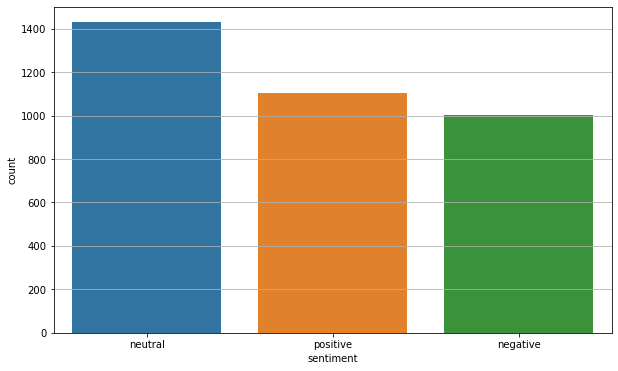

In [59]:
# Test data 
sns.countplot(x=test['sentiment'],data=train)
plt.show()

In [60]:
percent_sentiment = test.groupby('sentiment').count()
percent_sentiment['percent'] = 100*(percent_sentiment['text']/train['sentiment'].count())
percent_sentiment.reset_index(level=0, inplace=True)
percent_sentiment

,sentiment,textID,text,percent
0,negative,1001,1001,3.642649
1,neutral,1430,1430,5.203785
2,positive,1103,1103,4.013828


In [61]:
# Positive tweet
print("Positive Tweet example :",test[test['sentiment']=='positive']['text'].values[0])
#negative_text
print("Negative Tweet example :",test[test['sentiment']=='negative']['text'].values[0])
#neutral_text
print("Neutral tweet example  :",test[test['sentiment']=='neutral']['text'].values[0])

Positive Tweet example :  Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China:  (SH)  (BJ).
Negative Tweet example : Recession hit Veronique Branquinho, she has to quit her company, such a shame!
Neutral tweet example  : Last session of the day  http://twitpic.com/67ezh


In [62]:
# Distribution of the Sentiment Column
test['sentiment'].value_counts()

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

In [63]:
#Cleaning the train data 
test['text_clean_test'] = test['text'].apply(clean_str)

#Tokenizing and stopwords removing
test['tokeniZ_stopWords_text_test'] = test['text_clean_test'].apply(tokeniZ_stopWords)
#Words Stemming
test['stemming_text_test'] = [[ps.stem(word) for word in words] for words in test['tokeniZ_stopWords_text_test'] ]
test['stemming_text_for_tfidf_test'] = [' '.join(words) for words in test['stemming_text_test']] 

#Words lemmatization
test['lemmatize_text_test'] = test['tokeniZ_stopWords_text_test'].apply(lemat_words)
test['lemmatize_text_for_tfidf_test'] = [' '.join(x) for x in test['lemmatize_text_test'] ]

#Calcul longueur des commentaires
test['text_lenght_test'] = test['text'].apply(len)

#Calcul du nombre de ponctuation par question
from string import punctuation
test['number_punctuation_text_test'] = test['text'].apply(
    lambda doc: len([word for word in str(doc) if word in punctuation])) 

#Number of unique words in the text
test['number_of_Unique_words_text_test'] = test['text_clean_test'].apply([lambda x : len(set(str(x).split()))])
test
#Number of stopwords in the text
list_stopWords = set(stopwords.words('english'))
test['number_of_StopWords_text_test'] = test['text_clean_test'].apply(
    lambda x : len([w for w in x.lower().split() if w in list_stopWords ]))


#Number of upper case words
test['number_of_uppercase_text_test'] = test['text'].apply(
    lambda x : len([w for w in x.split() if w.isupper()]))


#Average length of words in the text (whithout stop words)
test['average_of_wordsLength_text_test'] = test['text_clean_test'].apply(
    lambda x : np.mean([len(w) for w in x.split()]))

#Number of words in the text
test['number_of_words_text_test'] = test['text_clean_test'].apply([lambda x : len(str(x).split())])

In [64]:
# Let's create three separate dataframes for positive, neutral and negative sentiments. 
#This will help in analyzing the text statistics separately for separate polarities.

positive_test = test[test['sentiment']=='positive']
negative_test = test[test['sentiment']=='negative']
neutral_test = test[test['sentiment']=='neutral']

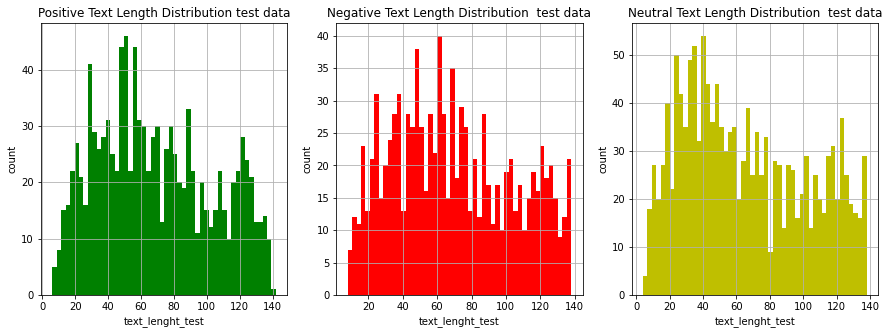

In [65]:
# Sentence length analysis

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(positive_test['text_lenght_test'],bins=50,color='g')
plt.title('Positive Text Length Distribution test data')
plt.xlabel('text_lenght_test')
plt.ylabel('count')


plt.subplot(1, 3, 2)
plt.hist(negative_test['text_lenght_test'],bins=50,color='r')
plt.title('Negative Text Length Distribution  test data')
plt.xlabel('text_lenght_test')
plt.ylabel('count')


plt.subplot(1, 3, 3)
plt.hist(neutral_test['text_lenght_test'],bins=50,color='y')
plt.title('Neutral Text Length Distribution  test data')
plt.xlabel('text_lenght_test')
plt.ylabel('count')
plt.show()

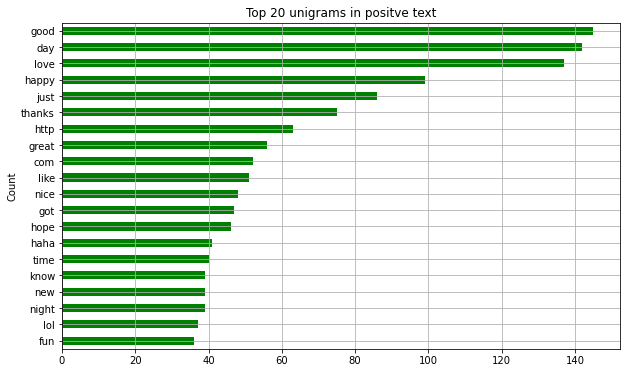

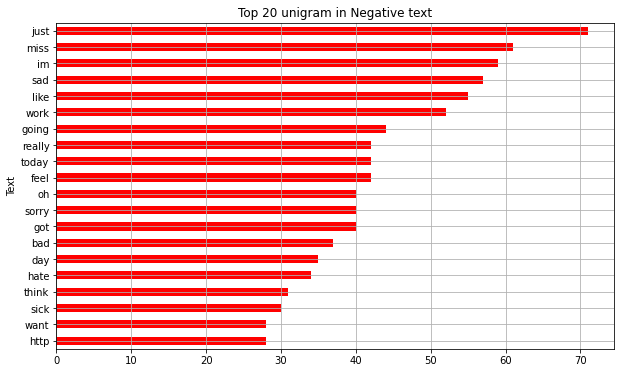

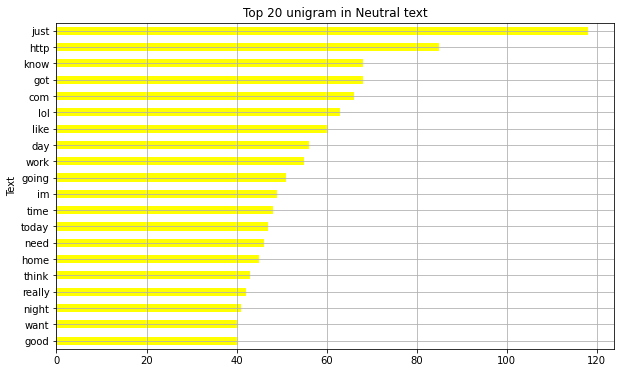

In [66]:
#Distribution of top unigrams
positive_test_unigrams = get_top_n_words(positive_test['text_clean_test'],20)
negative_test_unigrams = get_top_n_words(negative_test['text_clean_test'],20)
neutral_test_unigrams = get_top_n_words(neutral_test['text_clean_test'],20)

df1 = pd.DataFrame(positive_test_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='g')
plt.ylabel('Count')
plt.title('Top 20 unigrams in positve text')
plt.show()

df2 = pd.DataFrame(negative_test_unigrams, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='red')
plt.title('Top 20 unigram in Negative text')
plt.show()

df3 = pd.DataFrame(neutral_test_unigrams, columns = ['Text' , 'count'])
df3.groupby('Text').sum()['count'].sort_values(ascending=True).plot(kind='barh',color='yellow')
plt.title('Top 20 unigram in Neutral text')
plt.show()

In [67]:
#  Exploring the selected_text column

positive_text_test = test[test['sentiment'] == 'positive']['text']
negative_text_test = test[test['sentiment'] == 'negative']['text']
neutral_text_test = test[test['sentiment'] == 'neutral']['text']

In [68]:
# Preprocess Selected_text

positive_text_clean_test = positive_text_test.apply(clean_str)
negative_text_clean_test = negative_text_test.apply(clean_str)
neutral_text_clean_test = neutral_text_test.apply(clean_str)

In [69]:
top_words_in_positive_text_test = get_top_n_words(positive_text_clean_test)
top_words_in_negative_text_test = get_top_n_words(negative_text_clean_test)
top_words_in_neutral_text_test = get_top_n_words(neutral_text_clean_test)

p_test1 = [x[0] for x in top_words_in_positive_text_test[:20]]
p_test2 = [x[1] for x in top_words_in_positive_text_test[:20]]


n_test1 = [x[0] for x in top_words_in_negative_text_test[:20]]
n_test2 = [x[1] for x in top_words_in_negative_text_test[:20]]


nu_test1 = [x[0] for x in top_words_in_neutral_text_test[:20]]
nu_test2 = [x[1] for x in top_words_in_neutral_text_test[:20]]

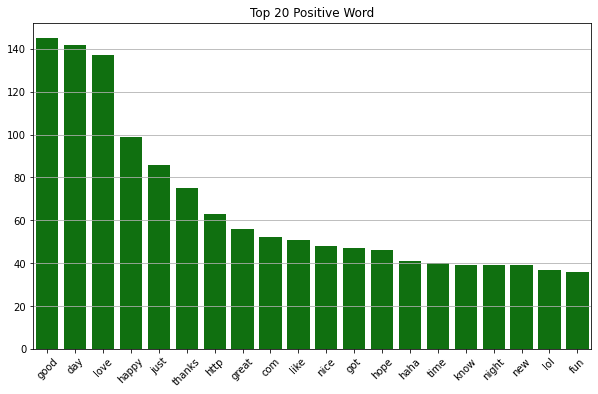

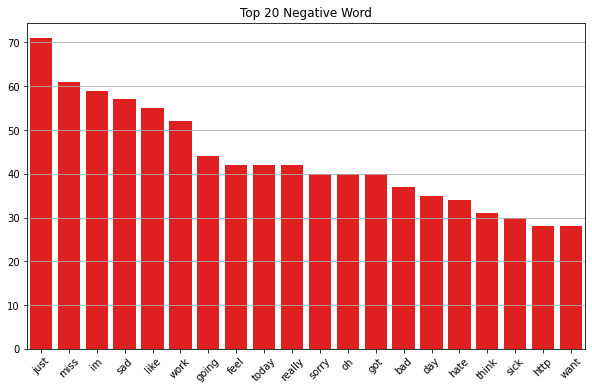

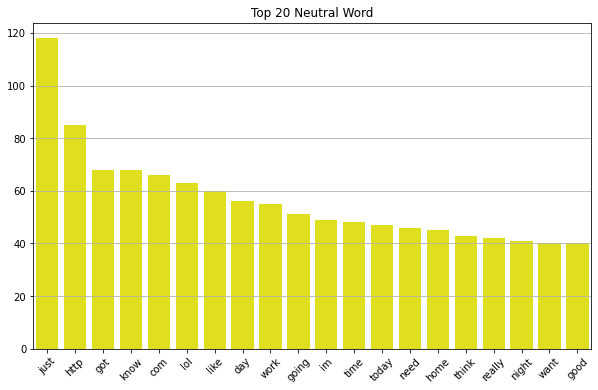

In [70]:
# Top positive word
sns.barplot(x=p_test1,y=p_test2,color = 'green')
plt.xticks(rotation=45)
plt.title('Top 20 Positive Word')
plt.show()

sns.barplot(x=n_test1,y=n_test2,color='red')
plt.xticks(rotation=45)
plt.title('Top 20 Negative Word')
plt.show()

sns.barplot(x=nu_test1,y=nu_test2,color='yellow')
plt.xticks(rotation=45)
plt.title('Top 20 Neutral Word')
plt.show()

Text(0.5, 1.0, 'Neutral text')

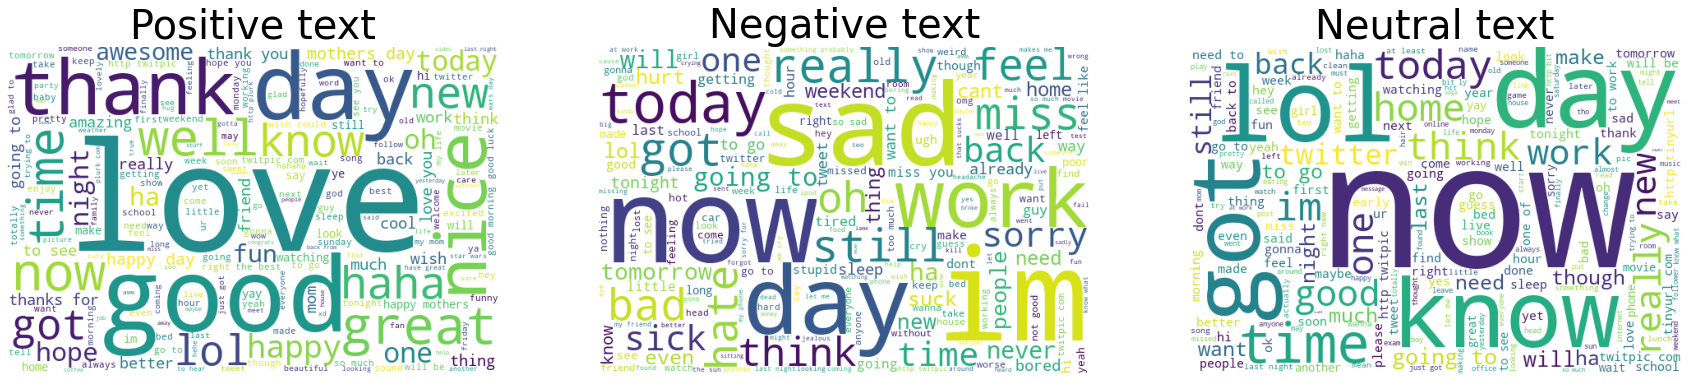

In [71]:
#Wordclouds
# Wordclouds to see which words contribute to which type of polarity.

from wordcloud import WordCloud
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean_test))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean_test))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean_test))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=40)

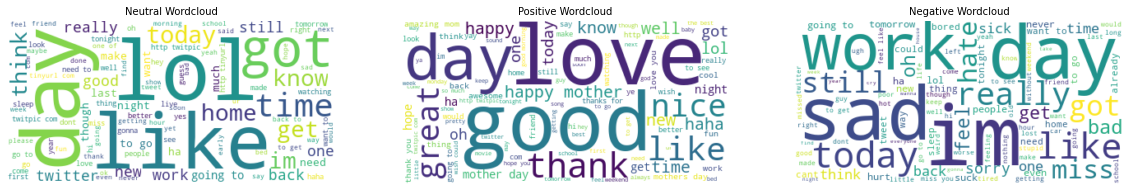

In [72]:
test_text_wc = generate_word_cloud(test, "text")



In [73]:
test.head()

,textID,text,sentiment,text_clean_test,tokeniZ_stopWords_text_test,stemming_text_test,stemming_text_for_tfidf_test,lemmatize_text_test,lemmatize_text_for_tfidf_test,text_lenght_test,number_punctuation_text_test,number_of_Unique_words_text_test,number_of_StopWords_text_test,number_of_uppercase_text_test,average_of_wordsLength_text_test,number_of_words_text_test
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day http twitpic com,"[last, session, day, http, twitpic, com]","[last, session, day, http, twitpic, com]",last session day http twitpic com,"[last, session, day, http, twitpic, com]",last session day http twitpic com,49,5,8,2,0,4.125000,8
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai is also really exciting precisely sky...,"[shanghai, also, really, exciting, precisely, ...","[shanghai, also, realli, excit, precis, skyscr...",shanghai also realli excit precis skyscrap gal...,"[shanghai, also, really, excite, precisely, sk...",shanghai also really excite precisely skyscrap...,103,11,14,2,2,5.357143,14
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho she has to ...,"[recession, hit, veronique, branquinho, quit, ...","[recess, hit, veroniqu, branquinho, quit, comp...",recess hit veroniqu branquinho quit compani shame,"[recession, hit, veronique, branquinho, quit, ...",recession hit veronique branquinho quit compan...,78,3,13,6,0,4.846154,13
3,01082688c6,happy bday!,positive,happy bday,"[happy, bday]","[happi, bday]",happi bday,"[happy, bday]",happy bday,12,1,2,0,0,4.500000,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,http twitpic com i like it,"[http, twitpic, com, like]","[http, twitpic, com, like]",http twitpic com like,"[http, twitpic, com, like]",http twitpic com like,39,8,6,2,1,3.500000,6


In [74]:
test['Target'] = test['sentiment'].apply(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)
test.head()

,textID,text,sentiment,text_clean_test,tokeniZ_stopWords_text_test,stemming_text_test,stemming_text_for_tfidf_test,lemmatize_text_test,lemmatize_text_for_tfidf_test,text_lenght_test,number_punctuation_text_test,number_of_Unique_words_text_test,number_of_StopWords_text_test,number_of_uppercase_text_test,average_of_wordsLength_text_test,number_of_words_text_test,Target
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,last session of the day http twitpic com,"[last, session, day, http, twitpic, com]","[last, session, day, http, twitpic, com]",last session day http twitpic com,"[last, session, day, http, twitpic, com]",last session day http twitpic com,49,5,8,2,0,4.125000,8,1
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,shanghai is also really exciting precisely sky...,"[shanghai, also, really, exciting, precisely, ...","[shanghai, also, realli, excit, precis, skyscr...",shanghai also realli excit precis skyscrap gal...,"[shanghai, also, really, excite, precisely, sk...",shanghai also really excite precisely skyscrap...,103,11,14,2,2,5.357143,14,2
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,recession hit veronique branquinho she has to ...,"[recession, hit, veronique, branquinho, quit, ...","[recess, hit, veroniqu, branquinho, quit, comp...",recess hit veroniqu branquinho quit compani shame,"[recession, hit, veronique, branquinho, quit, ...",recession hit veronique branquinho quit compan...,78,3,13,6,0,4.846154,13,0
3,01082688c6,happy bday!,positive,happy bday,"[happy, bday]","[happi, bday]",happi bday,"[happy, bday]",happy bday,12,1,2,0,0,4.500000,2,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,http twitpic com i like it,"[http, twitpic, com, like]","[http, twitpic, com, like]",http twitpic com like,"[http, twitpic, com, like]",http twitpic com like,39,8,6,2,1,3.500000,6,2


In [75]:
test[['text_lenght_test', 'number_punctuation_text_test', 'number_of_words_text_test',
       'number_of_Unique_words_text_test', 'number_of_StopWords_text_test', 'number_of_uppercase_text_test',
       'average_of_wordsLength_text_test']].sample(5)

,text_lenght_test,number_punctuation_text_test,number_of_words_text_test,number_of_Unique_words_text_test,number_of_StopWords_text_test,number_of_uppercase_text_test,average_of_wordsLength_text_test
2496,28,3,4,4,0,0,5.250000
417,15,0,3,3,1,0,4.333333
2775,50,1,7,7,3,0,5.285714
460,75,8,13,13,6,0,3.923077
2076,54,3,10,10,5,0,3.700000


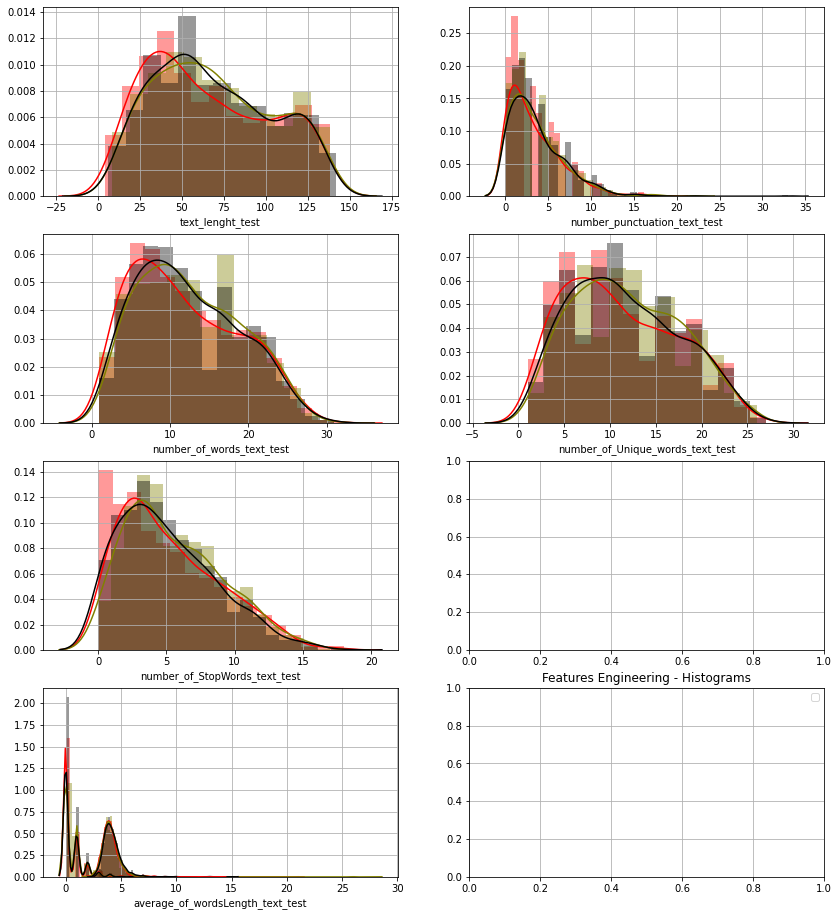

In [76]:
list_var=['text_lenght_test', 'number_punctuation_text_test', 'number_of_words_text_test',
       'number_of_Unique_words_text_test', 'number_of_StopWords_text_test', 'number_of_uppercase_text_test',
       'average_of_wordsLength_text_test']

    
var_hist_global(df=test,X='Target',Y=list_var, KDE=True)

## Feature selection 

In [77]:
test.columns

Index(['textID', 'text', 'sentiment', 'text_clean_test',
       'tokeniZ_stopWords_text_test', 'stemming_text_test',
       'stemming_text_for_tfidf_test', 'lemmatize_text_test',
       'lemmatize_text_for_tfidf_test', 'text_lenght_test',
       'number_punctuation_text_test', 'number_of_Unique_words_text_test',
       'number_of_StopWords_text_test', 'number_of_uppercase_text_test',
       'average_of_wordsLength_text_test', 'number_of_words_text_test',
       'Target'],
      dtype='object')

In [78]:
X_train =  train[['text_clean', 'stemming_text_for_tfidf', 'lemmatize_text_for_tfidf','tokeniZ_stopWords_text', 'stemming_text', 'lemmatize_text',
                             'text_lenght', 'number_punctuation_text', 'number_of_StopWords_text', 'number_of_Unique_words_text', 'number_of_uppercase_text','average_of_wordsLength_text']]
    



y_train = train['Target']

X_test = test[['text_clean_test','stemming_text_for_tfidf_test', 'lemmatize_text_for_tfidf_test', 'stemming_text_test', 'lemmatize_text_test', 'tokeniZ_stopWords_text_test', 
               'text_lenght_test', 'number_punctuation_text_test','number_of_Unique_words_text_test', 'number_of_StopWords_text_test', 
              'number_of_uppercase_text_test','average_of_wordsLength_text_test']]

y_test = test['Target']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27480, 12), (3534, 12), (27480,), (3534,))

# Vectorization 
## Text Tf-Idf Vectorizer training data 

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(  ngram_range=(1,1), 
                                     analyzer='word',
                                     stop_words='english', 
                                     lowercase=True, 
                                     max_df=0.9, # remove too frequent words
                                     min_df=10, # remove too rare words
                                     max_features = None, # max words in vocabulary, will keep most frequent words
                                     binary=False #If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.
                                  )



#Stemmed questions vectorzation
X_text_tfidf_vectorizer_train = tfidf_vectorizer.fit_transform(X_train['stemming_text_for_tfidf'])
X_text_tfidf_vectorizer_test = tfidf_vectorizer.transform(X_test['stemming_text_for_tfidf_test'])

#Lemmentized questions vectorization
X_text_tfidf_Lem_vect_train = tfidf_vectorizer.fit_transform(X_train['lemmatize_text_for_tfidf'])
X_test_tfidf_Lem_vect_test = tfidf_vectorizer.transform(X_test['lemmatize_text_for_tfidf_test'])


#bigram text vectorization
bigram_vectorizer = TfidfVectorizer(  ngram_range=(1,2), 
                                     analyzer='word',
                                     stop_words='english', 
                                     lowercase=True, 
                                     max_df=0.9, # remove too frequent words
                                     min_df=10, # remove too rare words
                                     max_features = None, # max words in vocabulary, will keep most frequent words
                                     binary=False #If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.
                                  )
X_text_bigram_vectorizer_train = bigram_vectorizer.fit_transform(X_train['stemming_text_for_tfidf'])
X_text_bigram_vectorizer_test = bigram_vectorizer.transform(X_test['lemmatize_text_for_tfidf_test'])


#T3gram questions vectorization
t3gram_vectorizer = TfidfVectorizer(  ngram_range=(1,4), 
                                     analyzer='word',
                                     stop_words='english', 
                                     lowercase=True, 
                                     max_df=0.9, # remove too frequent words
                                     min_df=10, # remove too rare words
                                     max_features = None, # max words in vocabulary, will keep most frequent words
                                     binary=False #If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.
                                  )
X_text_t3gram_vectorizer_train = t3gram_vectorizer.fit_transform(X_train['stemming_text_for_tfidf'])
X_text_t3gram_vectorizer_test  = t3gram_vectorizer.transform(X_test['stemming_text_for_tfidf_test'])

#Range single word to t3gram text vectorization
st3gram_vectorizer = TfidfVectorizer(  ngram_range=(1,3), 
                                     analyzer='word',
                                     stop_words='english', 
                                     lowercase=True, 
                                     max_df=0.9, # remove too frequent words
                                     min_df=10, # remove too rare words
                                     max_features = None, # max words in vocabulary, will keep most frequent words
                                     binary=False #If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.
                                  )
X_text_Singt3gram_vectorizer_train = st3gram_vectorizer.fit_transform(X_train['stemming_text_for_tfidf'])
X_text_Singt3gram_vectorizer_test  = st3gram_vectorizer.transform(X_test['stemming_text_for_tfidf_test'])


In [80]:
selected_text_tfidf_vectorizer_train = tfidf_vectorizer.fit_transform(train['stemming_selected_text_for_tfidf'])

selected_text_tfidf_Lem_vect_train = tfidf_vectorizer.fit_transform(train['lemmatize_selected_text_for_tfidf'])

selected_text_bigram_vectorizer_train = bigram_vectorizer.fit_transform(train['stemming_selected_text_for_tfidf'])

selected_text_t3gram_vectorizer_train = t3gram_vectorizer.fit_transform(train['stemming_selected_text_for_tfidf'])
selected_text_Singt3gram_vectorizer_train = st3gram_vectorizer.fit_transform(train['stemming_selected_text_for_tfidf'])



## Text Word embedding - Doc2Vec 

In [81]:
#Word2Vec with preprocessiong text (without stopwords) 
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

d2v_training_data = []
for i, doc in enumerate(X_train['stemming_text']):
    d2v_training_data.append(TaggedDocument(words=doc,tags=[i]))

# ========== learning doc embeddings with doc2vec ==========

# PV stands for 'Paragraph Vector'
# PV-DBOW (distributed bag-of-words) dm=0

d2v = Doc2Vec(d2v_training_data, vector_size=300, window=10, alpha=0.1, min_alpha=1e-4, dm=0, negative=1, epochs=10, min_count=2, workers=4)
d2v_vecs = np.zeros((len(X_train['stemming_text']), 300))
for i in range(len(X_train['stemming_text'])):
    d2v_vecs[i,:] = d2v.docvecs[i]
    
d2v_test = np.zeros((len(X_test['stemming_text_test']), 300))
for i in range(len(X_test['stemming_text_test'])):
    d2v_test[i,:] = d2v.infer_vector(X_test['stemming_text_test'].iloc[i])
    


In [82]:
#Word2Vec with lemmatize words
d2v_training_data = []
for i, doc in enumerate(X_train['lemmatize_text']):
    d2v_training_data.append(TaggedDocument(words=doc,tags=[i]))

# ========== learning doc embeddings with doc2vec ==========

# PV stands for 'Paragraph Vector'
# PV-DBOW (distributed bag-of-words) dm=0

d2v = Doc2Vec(d2v_training_data, vector_size=200, window=5, alpha=0.1, min_alpha=1e-4, 
              dm=0, negative=1, epochs=10, min_count=2, workers=4)
d2v_vecs_bigram = np.zeros((len(X_train['lemmatize_text']), 200))
for i in range(len(X_train['lemmatize_text'])):
    d2v_vecs_bigram[i,:] = d2v.docvecs[i]
    
d2v_test_bigram = np.zeros((len(X_test['lemmatize_text_test']), 200))
for i in range(len(X_test['lemmatize_text_test'])):
    d2v_test_bigram[i,:] = d2v.infer_vector(X_test['lemmatize_text_test'].iloc[i])
    


In [83]:
X_train

,text_clean,stemming_text_for_tfidf,lemmatize_text_for_tfidf,tokeniZ_stopWords_text,stemming_text,lemmatize_text,text_lenght,number_punctuation_text,number_of_StopWords_text,number_of_Unique_words_text,number_of_uppercase_text,average_of_wordsLength_text
0,have responded if i were going,respond go,respond go,"[responded, going]","[respond, go]","[respond, go]",36,2,4,6,1,4.166667
1,sooo sad i will miss you here in san diego,sooo sad miss san diego,sooo sad miss san diego,"[sooo, sad]","[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]",46,3,5,10,2,3.300000
2,my boss is bullying me,boss bulli,bos bully,[bullying],"[boss, bulli]","[bos, bully]",25,3,3,5,0,3.600000
3,what interview leave me alone,interview leav alon,interview leave alone,"[leave, alone]","[interview, leav, alon]","[interview, leave, alone]",31,1,2,5,0,5.000000
4,sons of why they put them on the releases we a...,son put releas alreadi bought,son put release already buy,[sons],"[son, put, releas, alreadi, bought]","[son, put, release, already, buy]",75,6,7,12,0,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
27476,wish we could come see u on denver husband los...,wish could come see u denver husband lost job ...,wish could come see u denver husband lose job ...,[lost],"[wish, could, come, see, u, denver, husband, l...","[wish, could, come, see, u, denver, husband, l...",77,1,5,15,0,3.666667
27477,wondered about rake to the client has made it ...,wonder rake client made clear net forc dev lea...,wonder rake client make clear net force devs l...,[force],"[wonder, rake, client, made, clear, net, forc,...","[wonder, rake, client, make, clear, net, force...",122,7,8,20,1,3.952381
27478,yay good for both of you enjoy the break you p...,yay good enjoy break probabl need hectic weeke...,yay good enjoy break probably need hectic week...,"[yay, good]","[yay, good, enjoy, break, probabl, need, hecti...","[yay, good, enjoy, break, probably, need, hect...",111,2,9,20,0,4.095238
27479,but it was worth it,worth,worth,[worth],[worth],[worth],27,5,4,4,0,3.000000


In [84]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SelectPercentile
from sklearn.pipeline import Pipeline

features = SelectKBest(mutual_info_classif,k=2).fit(X_train[['text_lenght', 'number_punctuation_text','number_of_Unique_words_text', 'number_of_StopWords_text', 
                                                             'number_of_uppercase_text','average_of_wordsLength_text']].fillna(0),y_train)
independance_test = np.zeros((6,2))
for idx,i in enumerate(['text_lenght', 'number_punctuation_text', 'number_of_Unique_words_text', 'number_of_StopWords_text', 'number_of_uppercase_text',
                        'average_of_wordsLength_text']):
    #independance_test[idx,0]= features.pvalues_[idx]
    independance_test[idx,1]= features.scores_[idx]
    #print (i,features.pvalues_[idx],features.scores_[idx])
    #print('%s  %s'%(i,features.scores_[idx]))

    
    
list_var=['text_lenght', 'number_punctuation_text','number_of_Unique_words_text', 'number_of_StopWords_text', 'number_of_uppercase_text',
          'average_of_wordsLength_text']
independance_df = pd.DataFrame({'Variables': list_var, 'p_values': independance_test[:,0], 'MI': independance_test[:,1]},index=None)
independance_df

,Variables,p_values,MI
0,text_lenght,0.0,0.010734
1,number_punctuation_text,0.0,0.003184
2,number_of_Unique_words_text,0.0,0.003412
3,number_of_StopWords_text,0.0,0.000814
4,number_of_uppercase_text,0.0,0.001532
5,average_of_wordsLength_text,0.0,0.006481


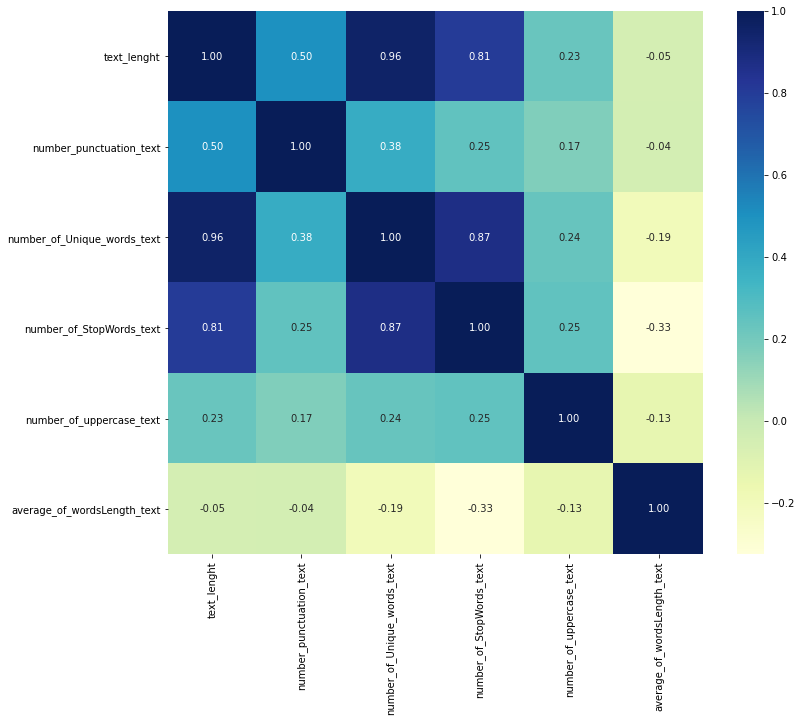

In [85]:
plt.figure(figsize=(12, 10))
_ = sns.heatmap(train[['text_lenght', 'number_punctuation_text','number_of_Unique_words_text', 'number_of_StopWords_text', 'number_of_uppercase_text','average_of_wordsLength_text']].corr()
                ,cmap="YlGnBu", annot=True, fmt=".2f")
plt.savefig("Correlation Matrice")
plt.show()

## Modelisation 

In [86]:
#!pip install hpelm

In [87]:
from sklearn import svm 

## Prediction 

In [88]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, KFold
random_state = 42
kf = KFold(n_splits=2,random_state=random_state)
n_iter= 50

In [89]:
from sklearn.neural_network import MLPClassifier
Model_final_MLPClassifier = MLPClassifier(random_state=random_state).fit(X_text_tfidf_vectorizer_train,y_train)

In [90]:
## Predictions 

Predictions = Model_final_MLPClassifier.predict(X_text_tfidf_vectorizer_test)

In [93]:
sample_submission

,textID,selected_text
0,f87dea47db,1
1,96d74cb729,2
2,eee518ae67,0
3,01082688c6,2
4,33987a8ee5,2
...,...,...
3529,e5f0e6ef4b,0
3530,416863ce47,2
3531,6332da480c,0
3532,df1baec676,1


In [92]:
sample_submission['selected_text'] = Predictions
sample_submission['selected_text'] = sample_submission['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
sample_submission['selected_text'] = sample_submission['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
sample_submission['selected_text'] = sample_submission['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

AttributeError: 'int' object has no attribute 'split'

In [ ]:
sentiment_list = { 0: 'negative', 
                  2 : 'positive', 
                  1: 'neutral'}

In [ ]:
#sentiment_list

In [ ]:

sample_submission['Sentiment_pred'] = sample_submission['Sentiment_preds'].map(sentiment_list)
sample_submission.head()

In [ ]:
sample_submission['text2'] = sample_submission["text"].apply(lambda x: x.split())
sample_submission

In [ ]:
text2 = sample_submission['text2']
text2

In [ ]:
text2 = [l[-int(Predictions.tolist()[ind]):] for ind, l in enumerate(text2)]

In [ ]:
text2[:5]

In [ ]:
sample_submission['text22'] = text2
sample_submission.head()

In [ ]:
sample_submission['selected_text'] = sample_submission["text22"].apply(lambda x: " ".join(x))
sample_submission

In [ ]:
submission   = sample_submission[['textID', "selected_text"]]
submission

In [ ]:
submission.to_csv('submission.csv', index=False)